In [1]:
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir)

In [2]:
currentdir

'/home/jcolbois/myopic-dual-worm/dualworm-kagome/AnalysisCode_PSI'

In [3]:
import DualwormFunctions as dw
import Observables as obs

#%load_ext line_profiler
#%load_ext memory_profiler

import RunBasis
import argparse
import StartStates as strst
import numpy as np

import AnalysisFunctions as af # functions to make the analysis code cleaner
import KagomeDrawing as kdraw
import KagomeFunctions as kf
    #plots using matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.animation import FuncAnimation
import importlib


In [4]:

nt = 64
nh = 1 # no field
ncores = 8

L = 8
J1 = 1
J2 = 0
h = 0
tmin = 5
print(tmin)

measupdate = True
saveupdates = True
genMode = measupdate
if genMode:
    nst = 0 # no thermalization update
    nsm = 1 # 1 measurement
    nips = 0; # no updates
    nrps = 0; # no replica
    nb = 1;
    measperiod =1; # measure once
    verbose = True
else:
    nst = 512 # we thermalize the samples
    nsm = 0; # no measurements
    nips = 1;
    nrps = 0;
    nb = 1
    measperiod =0;
    verbose = False
nmaxiter = nips
loadfromfile = measupdate
htip = 1 # to make it clear we do all with htip = 1
ttip = 0
#versions = [-1,3,4,5,6,7,8] # We are going to explore all relevant versions, in particular:
## -1 will mean no update for us
version = 4
pswitch = 1 # to make it clear we do all with p = 1
uponly = True # because uponly = False doesn't make sense
if not measupdate:
    htip = 0

stroutput =\
"../../Analysis_PSI_EPFL/TipEffectGifs/NOTGS_PSIMeasupdate_PathGIFs_J1={0}_L={1}_htip={2}_ttip={3}".format(J1,L,htip,ttip,pswitch,uponly) + \
"_pswitch={4}_uponly={5}_path={6} ".format(J1,L,htip,ttip,pswitch,uponly, version)

if not measupdate:
    stroutput = "../../Analysis_PSI_EPFL/TipEffectGifs/NOTGS_PSIMeasupdate_PathGIFs_J1=1_L=8_htip=1_ttip=0_pswitch=1_uponly=True"

5


In [5]:
stroutput

'../../Analysis_PSI_EPFL/TipEffectGifs/NOTGS_PSIMeasupdate_PathGIFs_J1=1_L=8_htip=1_ttip=0_pswitch=1_uponly=True_path=4 '

In [6]:
def genArgs():
    parser = argparse.ArgumentParser()
    
    parser.add_argument('-f', type = str)

    parser.add_argument('--L', type = int, default = L, help = 'Lattice side size')

    # COUPLINGS
    parser.add_argument('--J1', type = float, default = J1,
                        help = 'NN coupling') # nearest-neighbour coupling
    parser.add_argument('--J2', type = float, default = J2,
                        help = '2nd NN coupling') # 2nd NN coupling
    parser.add_argument('--J3', type = float, default = 0.0,
                        help = '3rd NN coupling') # 3rd NN coupling
    parser.add_argument('--J4', type = float, default = 0.0,
                        help = '4th NN coupling') 
    #NUMBER OF STEPS AND ITERATIONS
    parser.add_argument('--nst', type = int, default = nst,
                        help = 'number of thermalisation steps') # number of thermalisation steps
    parser.add_argument('--nsm', type = int, default = nsm,
                        help = 'number of measurements steps') # number of measurement steps
    parser.add_argument('--nips', type = int, default = nips,
                        help = 'number of worm constructions per MC step')
    parser.add_argument('--nrps', type = int, default = nrps,
                        help = 'number of replica loops per MC step')
    parser.add_argument('--measperiod', type = int, default = measperiod,
                        help = 'number of nips worm building + swaps between measurements')
    parser.add_argument('--nb', type = int, default = nb,
                        help = 'number of bins')

    #PARALLELISATION
    parser.add_argument('--ncores', type = int, default = ncores,
                        help = 'number of threads to use')

    
    # INITIALISATION PARAMETERS
    parser.add_argument('--randominit', default = True, action ='store_true',
                        help = 'intialise the states randomly')
    parser.add_argument('--same', default = False, action = 'store_true',
                        help = '''initialise all temperatures with the same
                        state (debug purposes)''')
    parser.add_argument('--magninit', default = False, action = 'store_true',
                        help = '''initialise all the temperature with
                        one of the m=1/3 G.S.''')
    parser.add_argument('--magnstripes', default = False, action = 'store_true',
                       help = '''initialise all the temperature with
                       m=1/3 stripes''')
    parser.add_argument('--maxflip', default = False, action = 'store_true',
                       help = '''initialise all the temperature with
                       maximally flippable plateau''')
    parser.add_argument('--loadfromfile', default = loadfromfile, action = 'store_true',
                       help = '''initialise all the states with
                       results from a previously performed simulations''')
    parser.add_argument('--filename', type = str, 
                        default = '../../Analysis_PSI_EPFL/TipEffectGifs/NOTGS_PSIMeasupdate_PathGIFs_J1=1_L=8_htip=1_ttip=0_pswitch=1_uponly=True_folder',
                       help = '''initialise all the states with
                       results from a previously performed simulations''')
    
    #WORM PARAMETERS
    parser.add_argument('--nmaxiter', type = int, default = nmaxiter,
                        help = '''maximal number of segments in a loop update over the
                        size of the lattice (1 = 1times the number of dualbonds in the
                        lattice)''')
    parser.add_argument('--measupdate', default = measupdate, action = 'store_true',
                       help = '''activate to mimic the action of the measuring tip''')
    parser.add_argument('--measupdatev', type = int, default = version,
                       help = '''select the version of measupdate''')
    parser.add_argument('--saveupdates', default = saveupdates, action = 'store_true',
                       help = '''activate to save the effect of the measuring tip (only genMode)''')
    parser.add_argument('--htip', type = float, default = htip, 
                       help = '''magnetic field associated with the tip''')
    parser.add_argument('--Ttip', type = float, default = ttip, 
                       help = '''temperature associated with the tip measurements''')
    parser.add_argument('--pswitch', type = float, default = pswitch, 
                       help = '''tip switching probability''')
    parser.add_argument('--uponly', type = float, default = uponly, 
                       help = '''Only switching down spins to up spins in measupdate''')
    parser.add_argument('--ssf', default = False, action = 'store_true',
                        help = 'activate for single spin flip update')
    parser.add_argument('--notfullssfupdate', default = False, action = 'store_true',
                        help = 'whether to fully update the state or not at each ssf step *during the measurement phase*')
    parser.add_argument('--alternate', default = True, action = 'store_true',
                        help = 'activate for single spin flip update and dw update')
    parser.add_argument('--checkgs', default = True, action = 'store_true',
                        help = 'activate to debug ssf')
    
    #TEMPERATURE PARAMETERS
    parser.add_argument('--t_list', nargs = '+', type = float, default = [tmin,20],
                        help = 'list of limiting temperature values')
    parser.add_argument('--nt_list', nargs = '+', type = int, default = [nt],
                        help = 'list of number of temperatures in between the given limiting temperatures')
    parser.add_argument('--log_tlist', default = True, action='store_true',
                        help = 'state whether you want the temperature be spaced log-like or linear-like (activate if you want log)')
    parser.add_argument('--stat_temps_lims', nargs = '+', type = float,
                        help = '''limiting temperatures for the various ranges of
                        measurements''') 
                        #default will be set to none, and then we can decide what to do later on.
    #MAGNETIC FIELD PARAMETERS
    parser.add_argument('--h_list', nargs = '+', default = [0,h],type = float,
                        help = 'list of limiting magnetic field values')
    parser.add_argument('--nh_list', nargs = '+', default = [nh], type = int,
                        help = 'list of number of magnetic fields in between the given limiting temperatures')
    parser.add_argument('--stat_hfields_lims', nargs = '+', type = float,
                help = '''limiting magnetic fields for the various ranges of
                measurements''') 
    #MEASUREMENTS PARAMETERS
    parser.add_argument('--generatingMode', default = genMode, action = 'store_true',
                        help = 'activate if you want to generate a number of ground states and low energy states')
    parser.add_argument('--energy', default = True, action = 'store_true',
                        help = 'activate if you want to save the energy')
    parser.add_argument('--magnetisation', default = True, action = 'store_true',
                        help = 'activate if you want to save the magnetisation')
    parser.add_argument('--charges', default = True, action = 'store_true',
                        help = 'activate if you want to save the charges')
    parser.add_argument('--frustratedT', default = True, action = 'store_true',
                        help = 'activate if you want to save the frustrated triangles')
    parser.add_argument('--correlations', default = True, action = 'store_true',
                        help = 'activate if you want to save either central or all correlations')
    parser.add_argument('--both', default = True, action = 'store_true',
                        help = '''activate if you want to save both types of correlations''')
    parser.add_argument('--firstcorrelations', default = False, action = 'store_true',
                        help = 'activate if you want to save first correlations, otherwise will save central')
    parser.add_argument('--sref0', nargs = '+', type = int, default = [L-2, L-1, 0], help = 'ref spin 0')
    parser.add_argument('--sref1', nargs = '+', type = int, default = [L-2, L-1, 1], help = 'ref spin 1')
    parser.add_argument('--sref2', nargs = '+', type = int, default = [L-2, L-1, 2], help = 'ref spin 2')
    
    #SAVE
    parser.add_argument('--output', type = str, default = stroutput, help = 'saving filename (.pkl will be added)')
    parser.add_argument('--verbose',default = verbose, action = 'store_true',
                        help = 'activate verbosity')
    args = parser.parse_args()
    return args



In [7]:
def callRunBasis():
    args = genArgs()
    return RunBasis.main(args)

In [8]:
[meanstat, swapst, swapsh, failedupdatesth, failedupdates, failedssfupdates] = callRunBasis()


-------------------Initialisation--------------------
./../../Analysis_PSI_EPFL/TipEffectGifs/NOTGS_PSIMeasupdate_PathGIFs_J1=1_L=8_htip=1_ttip=0_pswitch=1_uponly=True_path=4 _folder/backup.hkl
Lattice side size:  8
J1  1
J2  0
J3  0.0
J3st  0.0
Couplings extracted
Hamiltonian expression (without field) computed
alternating ssf and dw update
Number of temperatures:  64
Temperatures: [ 5.          5.1112428   5.2249606   5.34120845  5.46004266  5.58152075
  5.70570155  5.8326452   5.96241316  6.09506827  6.23067477  6.36929831
  6.51100604  6.65586655  6.80395     6.9553281   7.11007414  7.26826305
  7.42997145  7.59527762  7.76426161  7.93700526  8.1135922   8.29410795
  8.47863992  8.66727745  8.8601119   9.05723664  9.25874712  9.46474092
  9.67531779  9.89057968 10.11063084 10.33557783 10.56552956 10.80059739
 11.04089514 11.28653916 11.53764842 11.79434449 12.05675168 12.32499705
 12.5992105  12.8795248  13.16607569 13.45900193 13.75844535 14.06455096
 14.37746697 14.69734492 15.02

/home/jcolbois/myopic-dual-worm/dualworm-kagome/RunBasis.py:183: UserWarning: Lowest temperature state not in the ground state after thermalisation
  warnings.warn("Lowest temperature state not in the ground state after thermalisation")


Time for mcsevolve = 0.0006337165832519531
Time for tempering = 2.1457672119140625e-06
Time for mapping to spins + computing statistics= 0.23953747749328613
Time for all measurements steps =  0.4541153907775879
Energies size:  (64, 1)
RunBasis: Away from gs at t index  0
   en_states[t] =  -200.0
   ref_energy =  -384.0
Energies Checked
States Checked
ids2walker shape (64, 1)
Job done


In [9]:
# Create a folder to save the pictures
foldername = "./" + stroutput + "_folder/" 
results_foldername = 'Results/'
os.makedirs(foldername + results_foldername, exist_ok = True)

filenamelist = ["backup"]
n = len(filenamelist)

In [10]:
[L, numsites, J1, J2, J3, J3st, J4, nb, num_in_bin, 
 htip, Ttip, pswitch, uponly, path,
 temperatures, nt,
 stat_temps, temperatures_plots, hfields, nh, 
 stat_hfields, hfields_plots, listfunctions, sref, ids2walker] =\
af.LoadParameters(foldername, filenamelist)

In [11]:
updates = af.LoadUpdateLists(foldername, filenamelist)

In [12]:
print(updates[0][0,0].shape)

(1152,)


In [13]:
[d_ijl, ijl_d, s_ijl, ijl_s, d_2s, s2_d, d_nd, d_vd, d_wn,
     sidlist, didlist, c_ijl, ijl_c, c2s, csign] =\
    dw.latticeinit(L[0])
print(ids2walker[0][0,0])

0


In [14]:
[groundspinstates, groundstates, groundcharges] = \
af.LoadGroundStates(stroutput+"_folder/", filenamelist, L, nh, [nsm])

groundspinstates = groundspinstates[0]
groundstates = groundstates[0]
groundcharges = groundcharges[0]

stlen = len(s_ijl)

In [15]:
couplings = {'J1':J1[0], 'J2':J2[0],'J3':J3[0], 'J3st':J3[0]}
hamiltonian = dw.Hamiltonian(couplings, d_ijl, ijl_d, L[0])

In [16]:
def getPositions(s_ijl,a = 2):
    pos = {} #empty dictionary
    for s, (i,j,l) in enumerate(s_ijl):
        x = a * (i + j / 2.0)
        y = a * j * np.sqrt(3) / 2.0
        if l == 0:
            x += a / 2.0
        if l == 1:
            x += a / 4.0
            y += a * np.sqrt(3) / 4.0
        if l == 2:
            x -= a / 4.0
            y += a * np.sqrt(3) / 4.0
        pos[s] = (x,y)
    return pos

[0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 1 1 0 0 1 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
-0.024305555555555556


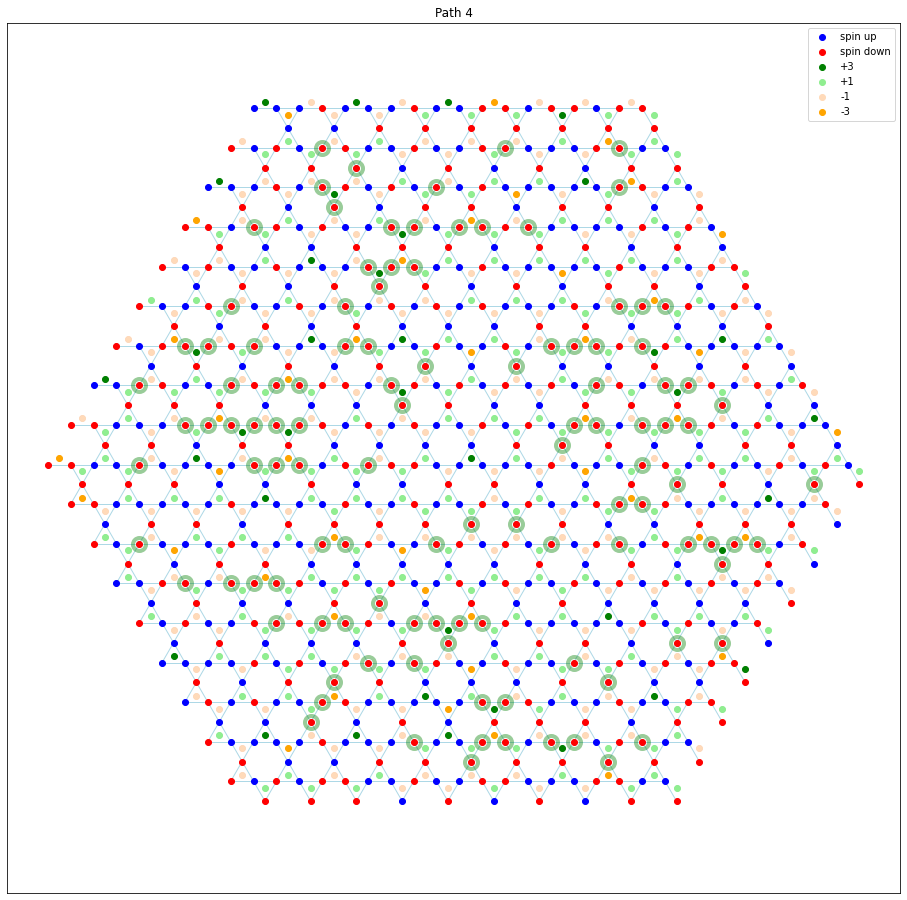

In [17]:
pos = getPositions(s_ijl, a = 2)
path = kf.path_for_measupdate(s_ijl, ijl_s, s2_d, L[0], version)
xy = np.asarray([pos[v] for v in path])


# check
state = groundstates[0]
spinstate = groundspinstates[0]
spinstatebool = ((spinstate+1)//2).astype(bool)
charges = obs.charges(0, state, 0 , spinstate, s_ijl, ijl_s,c2s = c2s , csign= csign)
charges = groundcharges[0]
a = 2 #lattice parameter
fig, ax = kdraw.plotstate(0, L[0], d_ijl, ijl_s, sidlist, didlist, s2_d, [state], [spinstate],
                    dim_node_color = np.array([[1, 1, 0, 0]]), dim_color =np.array([[1, 1, 0, 0]]), 
                    no_dim_color=np.array([[1, 1, 0, 0]]),
                    spin_up_color = 'blue', spin_down_color = 'red', dimerlinewidth=2)
kdraw.plot_honeycomb_chargestate(charges, ijl_c,
                                 L[0],2,c1_color = 'green', c2_color = 'lightgreen',
                                 c3_color = 'peachpuff', c4_color = 'orange')
xyspinsup = np.asarray([pos[v] for v, val in enumerate(spinstatebool) if val])
xyspinsdown = np.asarray([pos[v] for v, val in enumerate(spinstatebool) if not val])

xyspinsupdated = np.asarray([pos[path[index]] for index, val in enumerate(updates[0][0,0,:]) if val])


#spinsup, = ax.plot(xyspinsup[:,0], xyspinsup[:,1], 'o', fillstyle='none', markersize = 13, color = "blue")
#spinsdown, = ax.plot(xyspinsdown[:,0], xyspinsdown[:,1], 'o', fillstyle='none', markersize = 13, color = "red")
spinsupdated, = ax.plot(xyspinsupdated[:,0], xyspinsupdated[:,1], 'o',alpha = 0.4,fillstyle='none', markersize = 13, markeredgewidth = 4,color = "green")

#line, = ax.plot(xy[:,0],xy[:,1], '-',label = 'path', linewidth = 1)
plt.title("Path {0}".format(version))
plt.legend()
plt.savefig("./" + foldername + results_foldername + "/InitialStateCheck.png")

print(updates[0][0,0,:50])
print(spinstate[path[updates[0][0,0,:].astype(bool)]])
print(spinstate.sum()/spinstate.shape[0])

In [ ]:
a = 2 #lattice parameter

# reload results
n = 10
fig, ax = plt.subplots()

#kdraw.plot_kag_nodes(L[0], a, color = 'lightblue')
xyspinsup = np.asarray([pos[v] for v, val in enumerate(spinstatebool) if val])
xyspinsdown = np.asarray([pos[v] for v, val in enumerate(spinstatebool) if not val])
xyspinsupdated = np.asarray([pos[path[index]]
                             for index, val 
                             in enumerate(updates[0][0,0,:n]) if val])
 
spinsup, = ax.plot(xyspinsup[:,0], xyspinsup[:,1], '.', color = "blue")
spinsdown, = ax.plot(xyspinsdown[:,0], xyspinsdown[:,1], '.', color = "red")
spinsupdated, = ax.plot(xyspinsupdated[:,0], xyspinsupdated[:,1], 'o', 
                        fillstyle = 'none', markersize = 9, color = "green")

ax.axis('equal')
ax.tick_params(  
    which = 'both',      # both major and minor ticks are affected
    bottom = False,      # ticks along the bottom edge are off
    top = False,         # ticks along the top edge are off
    labelbottom = False,
    left = False,
    right = False,
    labelleft = False) # labels along the bottom edge are off

line, = ax.plot(xy[0:3*n,0],xy[0:3*n,1], '-',label = 'path', linewidth = 2)
line.set_xdata(xy[0:3*n,0])
line.set_ydata(xy[0:3*n,1])

def update(i):
    j = n*(i+1)
    
    label = 'Step {0}'.format(j)
    print(label)
    ax.set_title(label)
    jmax = min(xy.shape[0]-1, j)
    jmin = max(0, j-2*n)
    
    # get the updatelist associated to the file and update the spin
    # state accordingly
    updatessofar = np.concatenate([updates[0][0,0,0:jmax], np.zeros(xy.shape[0] - jmax)]).astype(bool)
    
    spinstatebool[path[updatessofar]] = \
    np.array([True for i in range(path[updatessofar].shape[0])])
    xyspinsup = np.asarray([pos[v] for v, val in enumerate(spinstatebool) if val])
    xyspinsdown = np.asarray([pos[v] for v, val in enumerate(spinstatebool) if not val])
    xyspinsupdated = np.asarray([pos[path[index]]
                             for index, val 
                             in enumerate(updatessofar) if val])

    
    spinsup.set_xdata(xyspinsup[:,0])
    spinsup.set_ydata(xyspinsup[:,1])
    
    spinsdown.set_xdata(xyspinsdown[:,0])
    spinsdown.set_ydata(xyspinsdown[:,1])
    
    
    spinsupdated.set_xdata(xyspinsupdated[:,0])
    spinsupdated.set_ydata(xyspinsupdated[:,1])

    line.set_xdata(xy[jmin:jmax,0])
    line.set_ydata(xy[jmin:jmax,1])
    #
    
    return ax

if __name__ == '__main__':
    print("yep")
    if version == 7:
        nsteps = 3360//n
    else:
        nsteps = 200//n
    anim = FuncAnimation(fig, update, frames=np.arange(0, nsteps), interval=200)
    anim.save("./" + foldername + results_foldername + "/PathUpdate.gif", dpi=100, writer='imagemagick')
    plt.show()

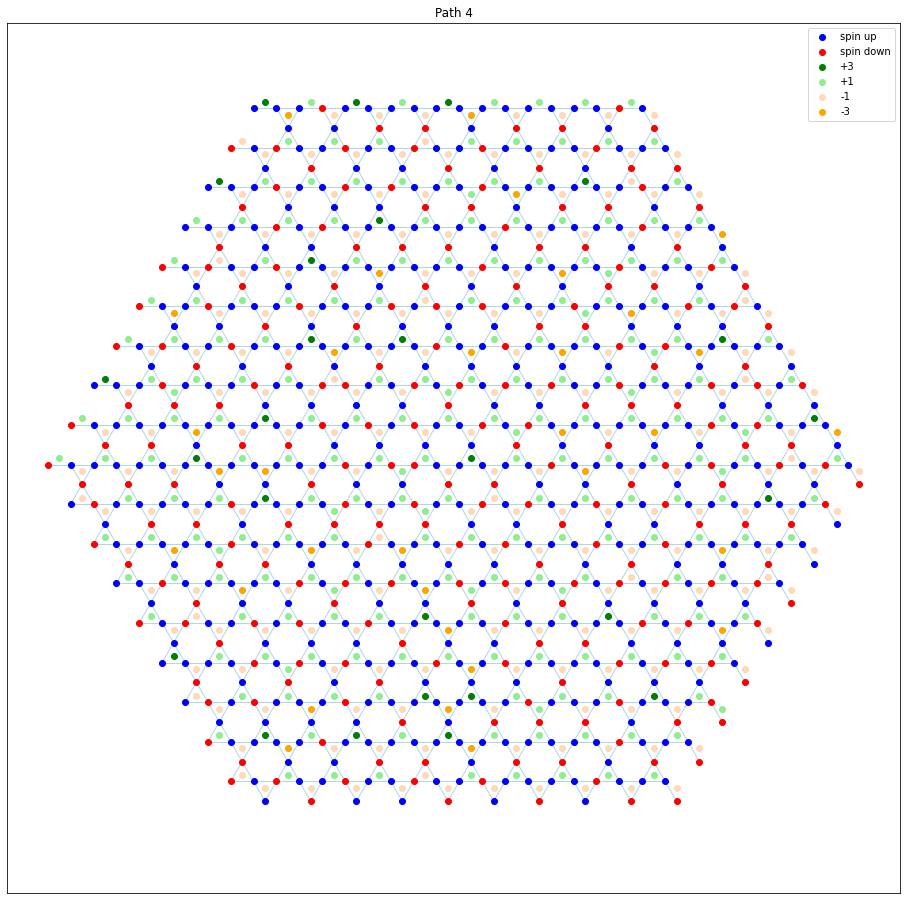

In [18]:
i = 0
state = groundstates[1]
spinstate = groundspinstates[1]
charges = obs.charges(0, state, 0 , spinstate, s_ijl, ijl_s,c2s = c2s , csign= csign)
charges = groundcharges[1]
a = 2 #lattice parameter
fig, ax = kdraw.plotstate(0, L[i], d_ijl, ijl_s, sidlist, didlist, s2_d, [state], [spinstate],
                    dim_node_color = np.array([[1, 1, 0, 0]]), dim_color =np.array([[1, 1, 0, 0]]), 
                    no_dim_color=np.array([[1, 1, 0, 0]]),
                    spin_up_color = 'blue', spin_down_color = 'red', dimerlinewidth=2)
kdraw.plot_honeycomb_chargestate(charges, ijl_c,
                                 L[0],2,c1_color = 'green', c2_color = 'lightgreen',
                                 c3_color = 'peachpuff', c4_color = 'orange')
plt.title("Path {0}".format(version))
plt.legend()
plt.savefig("./" + foldername + results_foldername + "/FinalState.png")